# Figure 2 - Optimization pipeline

Create the figure panels describing the model simplification pipeline.

### Imports

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from matplotlib.patches import Rectangle
from PySONIC.utils import logger, rescale, si_format
from PySONIC.plt import CompTimeSeries, cm2inch
from PySONIC.constants import NPC_DENSE
from PySONIC.neurons import getPointNeuron
from PySONIC.core import BilayerSonophore, NeuronalBilayerSonophore, PulsedProtocol, AcousticDrive
from utils import saveFigsAsPDF

### Plot parameters

In [2]:
figindex = 2
fs = 12
lw = 2
ps = 15
figs = {}

### Simulation parameters

In [3]:
pneuron = getPointNeuron('RS')
a = 32e-9  # m
drive = AcousticDrive(
    500e3,  # Hz
    100e3)  # Pa
Qm = -71.9e-5  # C/cm2
bls = BilayerSonophore(a, pneuron.Cm0, pneuron.Qm0)
nbls = NeuronalBilayerSonophore(a, pneuron)

## Panel A: approximation of intermolecular pressure

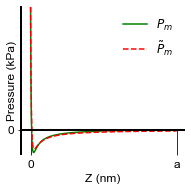

In [4]:
Z = np.linspace(-0.4 * bls.Delta_, bls.a, 1000)
fig, ax = plt.subplots(figsize=cm2inch(7, 7))
for key in ['right', 'top']:
    ax.spines[key].set_visible(False)
for key in ['bottom', 'left']:
    ax.spines[key].set_linewidth(2)
ax.spines['bottom'].set_position('zero')
ax.set_xlabel('Z (nm)', fontsize=fs)
ax.set_ylabel('Pressure (kPa)', fontsize=fs, labelpad=-10)
ax.set_xticks([0, bls.a * 1e9])
ax.set_xticklabels(['0', 'a'])
ax.tick_params(axis='x', which='major', length=25, pad=5)
ax.set_yticks([0])
ax.set_ylim([-10, 50])
for item in ax.get_xticklabels() + ax.get_yticklabels():
    item.set_fontsize(fs)
ax.plot(Z * 1e9, bls.v_PMavg(Z, bls.v_curvrad(Z), bls.surface(Z)) * 1e-3, c='g', label='$P_m$')
ax.plot(Z * 1e9, bls.PMavgpred(Z) * 1e-3, '--', c='r', label='$\~P_m$')
ax.axhline(y=0, color='k')
ax.legend(fontsize=fs, frameon=False)
fig.tight_layout()
figs['a'] = fig

## Panel B: recasting

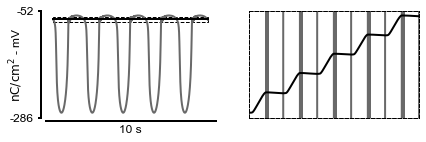

In [5]:
# Run effective simulation
data, _ = nbls.simulate(drive, PulsedProtocol(5 / drive.f, 0.), method='full')
t, Qm, Vm = [data[key].values for key in ['t', 'Qm', 'Vm']]
t *= 1e6  # us
Qm *= 1e5  # nC/cm2
Qrange = (Qm.min(), Qm.max())
dQ = Qrange[1] - Qrange[0]

# Create figure and axes
fig, axes = plt.subplots(1, 2, figsize=cm2inch(17, 5))
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])

# Plot Q-trace and V-trace
ax = axes[0]
for key in ['top', 'right']:
    ax.spines[key].set_visible(False)
for key in ['bottom', 'left']:
    ax.spines[key].set_position(('axes', -0.03))
    ax.spines[key].set_linewidth(2)
ax.plot(t, Vm, label='Vm', c='dimgrey', linewidth=lw)
ax.plot(t, Qm, label='Qm', c='k', linewidth=lw)
ax.add_patch(Rectangle(
    (t[0], Qrange[0] - 5), t[-1], dQ + 10,
    fill=False, edgecolor='k', linestyle='--', linewidth=1
))
ax.yaxis.set_tick_params(width=2)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
# ax.set_xlim((t.min(), t.max()))
ax.set_xticks([])
ax.set_xlabel('{}s'.format(si_format((t.max()), space=' ')), fontsize=fs)
ax.set_ylabel('$\\rm nC/cm^2$ - mV', fontsize=fs, labelpad=-15)
ax.set_yticks(ax.get_ylim())
for item in ax.get_yticklabels():
    item.set_fontsize(fs)

# Plot inset on Q-trace
ax = axes[1]
for key in ['top', 'right', 'bottom', 'left']:
    ax.spines[key].set_linewidth(1)
    ax.spines[key].set_linestyle('--')
ax.plot(t, Vm, label='Vm', c='dimgrey', linewidth=lw)
ax.plot(t, Qm, label='Qm', c='k', linewidth=lw)
ax.set_xlim((t.min(), t.max()))
ax.set_xticks([])
ax.set_yticks([])
delta = 0.05
ax.set_ylim(Qrange[0] - delta * dQ, Qrange[1] + delta * dQ)

figs['b'] = fig

## Panel C: mechanical simulation

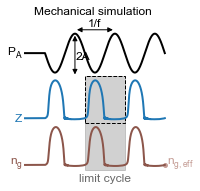

In [6]:
# Run mechanical simulation
Qm = -71.9e-5  # C/cm2
data, _ = bls.simulate(drive, Qm)
t, Z, ng = [data[key].values for key in ['t', 'Z', 'ng']]

# Create figure
fig, ax = plt.subplots(figsize=cm2inch(7, 7))
fig.suptitle('Mechanical simulation', fontsize=12)
for skey in ['bottom', 'left', 'right', 'top']:
    ax.spines[skey].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])

# Plot variables and labels
t_plot = np.insert(t, 0, -1e-6) * 1e6
Pac = drive.compute(t)  # Pa
yvars = {'P_A': Pac * 1e-3, 'Z': Z * 1e9, 'n_g': ng * 1e22}
colors = {'P_A': 'k', 'Z': 'C0', 'n_g': 'C5'}
dy = 1.2
for i, ykey in enumerate(yvars.keys()):
    y = yvars[ykey]
    y_plot = rescale(np.insert(y, 0, y[0])) - dy * i
    ax.plot(t_plot, y_plot, color=colors[ykey], linewidth=lw)
    ax.text(t_plot[0] - 0.1, y_plot[0], '$\mathregular{{{}}}$'.format(ykey), fontsize=fs,
            horizontalalignment='right', verticalalignment='center', color=colors[ykey])

# Acoustic pressure annotations
ax.annotate(s='', xy=(1.5, 1.1), xytext=(3.5, 1.1),
            arrowprops=dict(arrowstyle='<|-|>', color='k'))
ax.text(2.5, 1.12, '1/f', fontsize=fs, color='k',
        horizontalalignment='center', verticalalignment='bottom')
ax.annotate(s='', xy=(1.5, -0.1), xytext=(1.5, 1),
            arrowprops=dict(arrowstyle='<|-|>', color='k'))
ax.text(1.55, 0.4, '2A', fontsize=fs, color='k',
        horizontalalignment='left', verticalalignment='center')

# Periodic stabilization patch
ax.add_patch(Rectangle((2, -2 * dy - 0.1), 2, 2 * dy, color='dimgrey', alpha=0.3))
ax.text(3, -2 * dy - 0.2, 'limit cycle', fontsize=fs, color='dimgrey',
        horizontalalignment='center', verticalalignment='top')
# Z_last patch
ax.add_patch(Rectangle((2, -dy - 0.1), 2, dy, edgecolor='k', facecolor='none', linestyle='--'))

# ngeff annotations
c = plt.get_cmap('tab20').colors[11]
ax.text(t_plot[-1] + 0.1, y_plot[-1], '$\mathregular{n_{g,eff}}$', fontsize=fs, color=c,
        horizontalalignment='left', verticalalignment='center')
ax.scatter([t_plot[-1]], [y_plot[-1]], color=c, s=ps)

figs['c_mechsim'] = fig

## Panel C: cycle-averaging

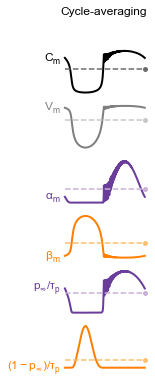

In [7]:
# Run mechanical simulation
data, _ = bls.simulate(drive, Qm)
t, Z, ng = [data[key].values for key in ['t', 'Z', 'ng']]

# Compute variables evolution over last acoustic cycle
t_last = t[-NPC_DENSE:] * 1e6  # us
Z_last = Z[-NPC_DENSE:]  # m
Cm = bls.v_capacitance(Z_last) * 1e2  # uF/m2
Vm = Qm / Cm * 1e5  # mV
yvars = {
    'C_m': Cm,  # uF/cm2
    'V_m': Vm,  # mV
    '\\alpha_m': pneuron.alpham(Vm) * 1e3,  # ms-1
    '\\beta_m': pneuron.betam(Vm) * 1e3,  # ms-1
    'p_\\infty / \\tau_p': pneuron.pinf(Vm) / pneuron.taup(Vm) * 1e3,  # ms-1
    '(1-p_\\infty) / \\tau_p': (1 - pneuron.pinf(Vm)) / pneuron.taup(Vm) * 1e3  # ms-1
}

# Determine colors
violets = plt.get_cmap('Paired').colors[8:10][::-1]
oranges = plt.get_cmap('Paired').colors[6:8][::-1]
colors = {
    'C_m': ['k', 'dimgrey'],
    'V_m': plt.get_cmap('tab20').colors[14:16],
    '\\alpha_m': violets,
    '\\beta_m': oranges,
    'p_\\infty / \\tau_p': violets,
    '(1-p_\\infty) / \\tau_p': oranges
}

# Create figure and axes
fig, axes = plt.subplots(6, 1, figsize=cm2inch(4, 15))
fig.suptitle('Cycle-averaging', fontsize=fs)
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    for skey in ['bottom', 'left', 'right', 'top']:
        ax.spines[skey].set_visible(False)

# Plot variables
for ax, ykey in zip(axes, yvars.keys()):
    ax.set_xticks([])
    ax.set_yticks([])
    for skey in ['bottom', 'left', 'right', 'top']:
        ax.spines[skey].set_visible(False)
    y = yvars[ykey]
    ax.plot(t_last, y, color=colors[ykey][0], linewidth=lw)
    ax.plot([t_last[0], t_last[-1]], [np.mean(y)] * 2, '--', color=colors[ykey][1])
    ax.scatter([t_last[-1]], [np.mean(y)], s=ps, color=colors[ykey][1])
    ax.text(t_last[0] - 0.1, y[0], '$\mathregular{{{}}}$'.format(ykey), fontsize=fs,
            horizontalalignment='right', verticalalignment='center', color=colors[ykey][0])

figs['c_cycleavg'] = fig

## Panel D: hybrid integration

No handles with labels found to put in legend.


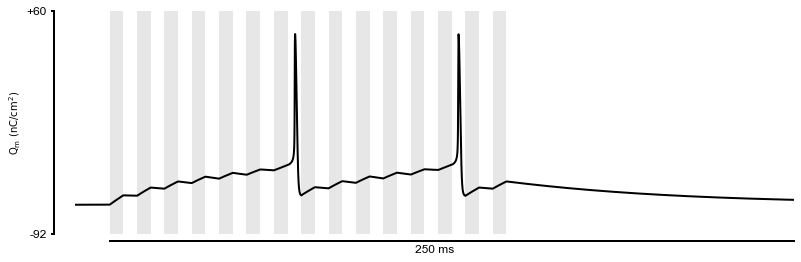

In [8]:
# Run effective simulation
pp = PulsedProtocol(150e-3, 100e-3, 100., 0.5)
data, meta = nbls.simulate(drive, pp, method='sonic')

# Plot charge density response
fig = CompTimeSeries([(data, meta)], 'Qm').render()
ax = fig.axes[0]
line = ax.lines[0]
line.set_color('k')
line.set_label(None)
ax.legend(fontsize=fs, frameon=False)
t = data['t'].values
ax.set_title('')
ax.set_xticks([])
ax.set_yticks([])
for key in ['top', 'right']:
    ax.spines[key].set_visible(False)
for key in ['bottom', 'left']:
    ax.spines[key].set_position(('axes', -0.03))
    ax.spines[key].set_linewidth(2)
ax.spines['bottom'].set_bounds(low=t.min() * 1e3, high=t.max() * 1e3)
ax.yaxis.set_tick_params(width=2)
ax.yaxis.set_major_formatter(FormatStrFormatter('%+.0f'))
ax.set_xticks([])
ax.set_xlabel('{}s'.format(si_format((t.ptp()), space=' ')), fontsize=fs)
ax.set_yticks(ax.get_ylim())
for item in ax.get_yticklabels():
    item.set_fontsize(fs)
    
figs['d'] = fig

### Save figure panels

Save figure panels as **pdf** in the *figs* sub-folder:

In [9]:
saveFigsAsPDF(figs, figindex)